<a href="https://www.kaggle.com/code/negardeylami/exploring-mental-health-dataset?scriptVersionId=250442071" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


# **Libraries**


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV

# Data Overview


In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")

In [4]:
train.shape

(140700, 20)

In [5]:
test.shape

(93800, 19)

In [6]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [7]:
# we need to handle non values
train.isnull().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [8]:
train = train.drop(columns=['id','Name'])
test = test.drop(columns=['Name'])

In [9]:
numeric_columns = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                   'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
                   'Financial Stress', 'Depression']


categorical_columns = ['Gender', 'City', 'Working Professional or Student',
                      'Profession', 'Sleep Duration', 'Dietary Habits',
                      'Degree', 'Have you ever had suicidal thoughts ?',
                      'Family History of Mental Illness']

for feature in categorical_columns:
  unique = train[feature].unique()
  print(f"column: {feature}")
  print(f"Unique Values: {unique}\n")

column: Gender
Unique Values: ['Female' 'Male']

column: City
Unique Values: ['Ludhiana' 'Varanasi' 'Visakhapatnam' 'Mumbai' 'Kanpur' 'Ahmedabad'
 'Thane' 'Nashik' 'Bangalore' 'Patna' 'Rajkot' 'Jaipur' 'Pune' 'Lucknow'
 'Meerut' 'Agra' 'Surat' 'Faridabad' 'Hyderabad' 'Srinagar' 'Ghaziabad'
 'Kolkata' 'Chennai' 'Kalyan' 'Nagpur' 'Vadodara' 'Vasai-Virar' 'Delhi'
 'Bhopal' 'Indore' 'Ishanabad' 'Vidhi' 'Ayush' 'Gurgaon' 'Krishna'
 'Aishwarya' 'Keshav' 'Harsha' 'Nalini' 'Aditya' 'Malyansh' 'Raghavendra'
 'Saanvi' 'M.Tech' 'Bhavna' 'Less Delhi' 'Nandini' 'M.Com' 'Plata'
 'Atharv' 'Pratyush' 'City' '3.0' 'Less than 5 Kalyan' 'MCA' 'Mira'
 'Moreadhyay' 'Morena' 'Ishkarsh' 'Kashk' 'Mihir' 'Vidya' 'Tolkata' 'Anvi'
 'Krinda' 'Ayansh' 'Shrey' 'Ivaan' 'Vaanya' 'Gaurav' 'Harsh' 'Reyansh'
 'Kashish' 'Kibara' 'Vaishnavi' 'Chhavi' 'Parth' 'Mahi' 'Tushar' 'MSc'
 'No' 'Rashi' 'ME' 'Molkata' 'Researcher' 'Kagan' 'Armaan' 'Ithal'
 'Nalyan' 'Dhruv' 'Galesabad' 'Itheg' 'Aaradhya' 'Pooja' 'Khushi'
 'Khaziabad

In [10]:
#cleaning the data
sleepmode = train['Sleep Duration'].mode()[0]
dietmode = train['Dietary Habits'].mode()[0]

train = train.replace({'Sleep Duration': {'Indore': sleepmode ,'Work_Study_Hours': sleepmode , 'Unhealthy': sleepmode,
"Pune": sleepmode, "Sleep_Duration": sleepmode, "than 5 hours": sleepmode, 'Moderate': sleepmode, 'No':sleepmode,
"40-45 hours": "4-5 hours", "55-66 hours": "5-6 hours", "35-36 hours": "4-6 hours", "45-48 hours":sleepmode,
"45": sleepmode, '49 hours': sleepmode}})

train = train.replace({'Dietary Habits':{
    'Yes': "Healthy", '1.0': "Healthy", 'Pratham': dietmode,  'BSc': dietmode, 'Gender': dietmode,
    '3': dietmode, 'M.Tech': dietmode, 'Mihir': dietmode,'Vegas': dietmode,'Male': dietmode,
    'Indoor': dietmode,'Male': dietmode,'Class 12': dietmode, '2': dietmode,  'Less Healthy' :"Unhealthy",
    "Hormonal":dietmode, 'Electrician':dietmode, 'No': 'Unhealthy','No Healthy':'Unhealthy', "More Healthy": "Healthy",
    'Less than Healthy': "Unhealthy"
}})


test = test.replace({'Sleep Duration': {'Indore': sleepmode ,'Work_Study_Hours': sleepmode , 'Unhealthy': sleepmode,
"Pune": sleepmode, "Sleep_Duration": sleepmode, "than 5 hours": sleepmode, 'Moderate': sleepmode, 'No':sleepmode,
"40-45 hours": "4-5 hours", "55-66 hours": "5-6 hours", "35-36 hours": "4-6 hours", "45-48 hours":sleepmode,
"45": sleepmode , '49 hours': sleepmode}})

test = test.replace({'Dietary Habits':{
    'Yes': "Healthy", '1.0': "Healthy", 'Pratham': dietmode,  'BSc': dietmode, 'Gender': dietmode,
    '3': dietmode, 'M.Tech': dietmode, 'Mihir': dietmode,'Vegas': dietmode,'Male': dietmode,
    'Indoor': dietmode,'Male': dietmode,'Class 12': dietmode, '2': dietmode,  'Less Healthy' :"Unhealthy",
    "Hormonal":dietmode, 'Electrician':dietmode, 'No': 'Unhealthy','No Healthy':'Unhealthy', "More Healthy": "Healthy",
    'Less than Healthy': "Unhealthy"
}})

print(train['Dietary Habits'].unique(),
train['Sleep Duration'].unique())

['Healthy' 'Unhealthy' 'Moderate' nan] ['More than 8 hours' 'Less than 5 hours' '5-6 hours' '7-8 hours'
 '1-2 hours' '6-8 hours' '4-6 hours' '6-7 hours' '10-11 hours' '8-9 hours'
 '4-5 hours' '9-11 hours' '2-3 hours' '3-4 hours' '9-6 hours' '1-3 hours'
 '1-6 hours' '8 hours' '10-6 hours' '3-6 hours' '9-5' '9-5 hours']


In [11]:
#finding missing values or typos in numerical values
for feature in numeric_columns:
  unique = train[feature].unique()
  print(f"column: {feature}")
  print(f"Unique Values: {unique}\n")

column: Age
Unique Values: [49. 26. 33. 22. 30. 59. 47. 38. 24. 42. 55. 51. 39. 29. 50. 23. 56. 45.
 37. 46. 31. 19. 28. 25. 41. 60. 18. 36. 21. 58. 44. 43. 40. 35. 54. 27.
 52. 48. 57. 53. 34. 20. 32.]

column: Academic Pressure
Unique Values: [nan  5.  2.  3.  4.  1.]

column: Work Pressure
Unique Values: [ 5.  4. nan  1.  2.  3.]

column: CGPA
Unique Values: [    nan  8.97    5.9     7.03    5.59    8.13    5.7     9.54    8.04
  9.79    8.38    6.1     7.04    8.52    5.64    8.58    6.51    7.25
  7.83    9.93    8.74    6.73    5.57    8.59    7.1     6.08    5.74
  9.86    6.7     6.21    5.87    6.37    9.72    5.88    9.56    6.99
  5.24    9.21    7.85    6.95    5.86    7.92    9.66    8.94    9.71
  7.87    5.6     7.9     5.46    6.79    8.7     7.38    8.5     7.09
  9.82    8.89    7.94    9.11    6.75    7.53    9.49    9.01    7.64
  5.27    6.      9.44    5.75    7.51    9.05    6.38    8.95    9.88
  5.32    6.27    7.7     8.1     9.59    8.96    5.51    7.43    8.

In [12]:
# handling null values using mean for numeric datas and mode for numerical datas
train[numeric_columns] = train[numeric_columns].fillna(train[numeric_columns].mean())
test[[col for col in numeric_columns if col != 'Depression']] = test[[col for col in numeric_columns if col != 'Depression']].fillna(test[[col for col in numeric_columns if col != 'Depression']].mean())

for col in categorical_columns:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])


print(train.isnull().sum())
print(train.head())

Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64
   Gender   Age           City Working Professional or Student  \
0  Female  49.0       Ludhiana            Working Professional   
1    Male  26.0       Varanasi            Working Professional   
2    Male  33.0

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['Depression']), train['Depression'], test_size=0.25, random_state=42 )
print(X_train.shape, X_test.shape)

(105525, 17) (35175, 17)


In [14]:
# normalization and one hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in numeric_columns if col != 'Depression']),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
,  remainder='drop')

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
test = preprocessor.transform(test)

In [15]:
import xgboost as xgb

In [16]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=200,            
    learning_rate=0.1,
    max_depth=8,
    use_label_encoder=False,      
    eval_metric='logloss',       
    random_state=42
)


In [17]:
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9373

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     28720
           1       0.84      0.82      0.83      6455

    accuracy                           0.94     35175
   macro avg       0.90      0.89      0.89     35175
weighted avg       0.94      0.94      0.94     35175



# Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV
from collections import Counter

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2], 
    'max_depth': [5, 8, 10, 13], 
    # 'subsample': [0.7, 0.9, 1.0], # Fraction of samples used for fitting the trees
    # 'colsample_bytree': [0.7, 0.9, 1.0], # Fraction of features used for fitting the trees
    # 'gamma': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition
    # 'lambda': [1, 2], # L2 regularization term
    # 'alpha': [0, 0.1] # L1 regularization term
    # IMPORTANT for imbalance:
    # 'scale_pos_weight': [1, (Counter(y_train)[0] / Counter(y_train)[1])]
    # Calculate scale_pos_weight based on training data: majority_class_count / minority_class_count
    'scale_pos_weight': [1, round(Counter(y_train)[0] / Counter(y_train)[1], 2)]
}

bestXGB = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=5, # Using 5-fold cross-validation
    scoring='roc_auc', # Optimize for Area Under the Receiver Operating Characteristic Curve
    # scoring='f1', # Alternatively, optimize for F1-score of the positive class
    verbose=2, # Higher verbosity prints more details during the search
    n_jobs=-1
)

In [19]:
bestXGB.fit(X_train, y_train)
print(f"\nBest parameters found: {bestXGB.best_params_}")
print(f"Best cross-validation score ({bestXGB.scoring}): {bestXGB.best_score_:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, scale_pos_weight=1; total time=   2.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, scale_pos_weight=4.52; total time=   2.5s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, scale_pos_weight=4.52; total time=   2.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=200, scale_pos_weight=1; total time=   4.1s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=200, scale_pos_weight=4.52; total time=   4.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=300, scale_pos_weight=1; total time=   6.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=300, scale_pos_weight=4.52; total time=   6.0s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=300, scale_pos_weight=4.52; total time=   5.8s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=100, scale_pos_weight=1; total time=   4.0s
[CV] END learning_rate=0.05, max

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, scale_pos_weight=1; total time=   2.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, scale_pos_weight=4.52; total time=   2.5s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=200, scale_pos_weight=1; total time=   4.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=200, scale_pos_weight=1; total time=   4.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=200, scale_pos_weight=4.52; total time=   4.3s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=300, scale_pos_weight=1; total time=   6.9s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=300, scale_pos_weight=4.52; total time=   5.9s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=100, scale_pos_weight=1; total time=   4.0s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=100, scale_pos_weight=4.52; total time=   4.3s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=100, scale_pos_weight=4.52; total time=   

In [20]:
best_xgb_model = bestXGB.best_estimator_

y_pred_best = best_xgb_model.predict(X_test)
y_pred_proba_best = best_xgb_model.predict_proba(X_test)[:, 1] # Probability for the positive class

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best) # ROC AUC requires probabilities

print(f"Test Set Accuracy: {accuracy_best:.4f}")
print(f"Test Set ROC AUC: {roc_auc_best:.4f}")

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_best))



Test Set Accuracy: 0.9396
Test Set ROC AUC: 0.9767

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     28720
           1       0.85      0.82      0.83      6455

    accuracy                           0.94     35175
   macro avg       0.90      0.89      0.90     35175
weighted avg       0.94      0.94      0.94     35175



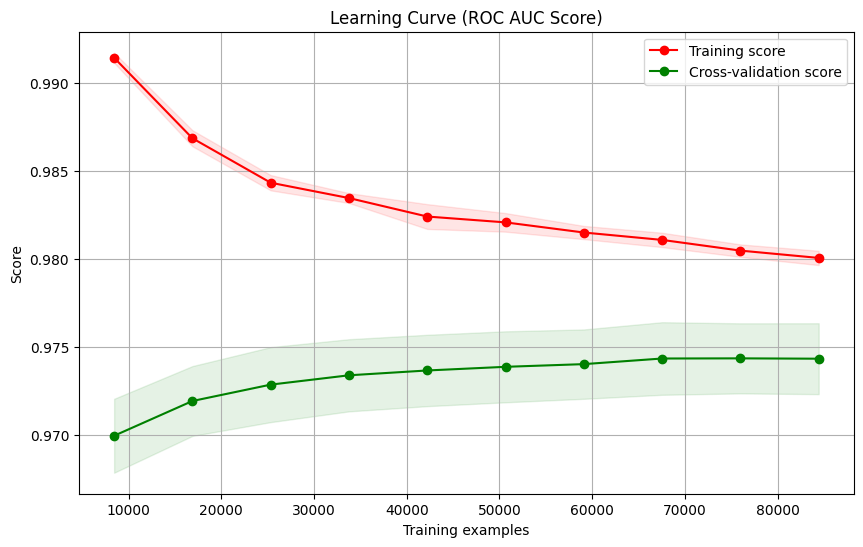

In [21]:
# Plot a learning curve
train_sizes, train_scores, test_scores = learning_curve(best_xgb_model, X_train, y_train, cv=5, n_jobs=-1,scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve (ROC AUC Score)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [22]:
sample_submission = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")
y_pred = best_xgb_model.predict(test)
submission_df = pd.DataFrame({'id': sample_submission['id'], 'Depression': y_pred})
submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!
